## Imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ! pip install aif360
# ! pip install cvxpy
# ! pip install BlackBoxAuditing

# import aif360
!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.25.2
  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<

In [ ]:
# Record the start time
start_time = time.time()

## Fairness metrics and functions


In [ ]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [ ]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [ ]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=123)

    cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [ ]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [ ]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [ ]:
# choose dataset
# DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME='CREDIT_SEX'
#DATASET_NAME = 'BANK_AGE'
#DATASET_NAME = 'BANK_AGE'
DATASET_NAME = 'RECRUIT_AGE'



In [ ]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv


Saving recruitmentdataset-2022-1.3.csv to recruitmentdataset-2022-1.3.csv
User uploaded file "recruitmentdataset-2022-1.3.csv" with length 315287 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [ ]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('../input/adult-census-income/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('../input/compastwoyears/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

elif DATASET_NAME == 'RECRUIT_AGE':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'age'
    PRIV_VALUE_FEATURE = 1
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']




## Data_Visualization

In [ ]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(937, 14) (330, 14) (1916, 14) (817, 14)


In [ ]:
maximum = max(orig_data_zero_priv.shape,orig_data_zero_non_priv.shape,orig_data_one_priv.shape,orig_data_one_non_priv.shape)
if maximum == orig_data_zero_priv.shape:
    print("orig_data_zero_priv is maximum")
if maximum == orig_data_zero_non_priv.shape:
    print("orig_data_zero_non_priv is maximum")
if maximum == orig_data_one_priv.shape:
    print("orig_data_one_priv is maximum")
if maximum == orig_data_one_non_priv.shape:
    print("orig_data_one_non_priv is maximum")

orig_data_zero_priv is maximum


In [ ]:
maximum = maximum[0]
print(maximum)

1916


In [ ]:
orig_data_zero_priv.shape[0]

1916

In [ ]:
orig_data_one_non_priv

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
7,1,0,Dutch,Swimming,71,False,True,False,False,1,True,master,A,1
9,0,0,Dutch,Football,55,True,False,False,True,3,False,master,A,1
19,1,0,Belgian,Running,63,False,False,False,False,1,True,bachelor,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,0,0,Dutch,Swimming,67,False,True,False,False,1,True,bachelor,D,1
3936,1,0,Dutch,Golf,72,False,True,False,False,1,True,bachelor,D,1
3955,1,0,Dutch,Swimming,71,False,True,False,False,1,True,master,D,1
3969,0,0,Dutch,Running,75,True,True,False,True,2,True,master,D,1


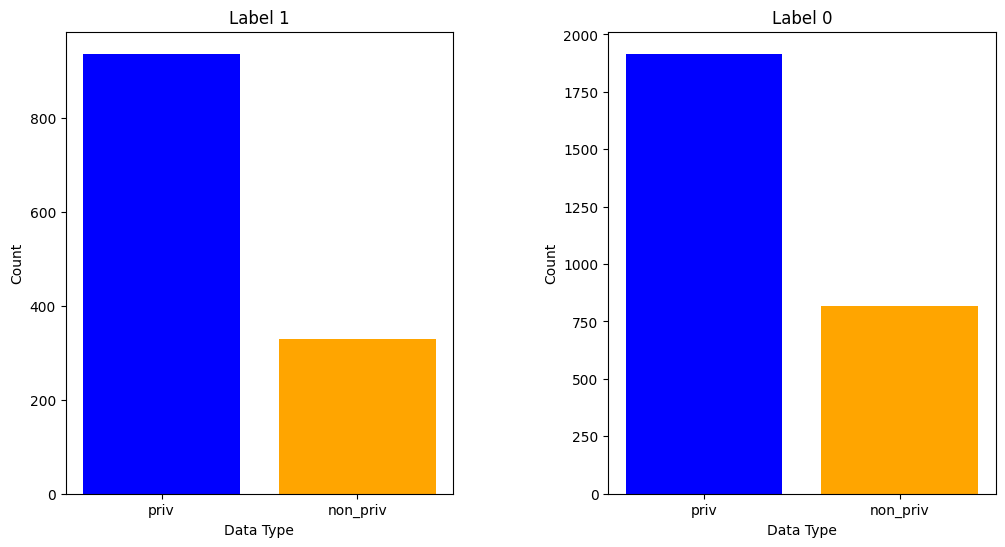

In [ ]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

In [ ]:
orig_data

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
1,0,1,German,Golf,67,False,True,False,False,2,True,bachelor,A,0
2,1,0,Dutch,Running,67,False,True,True,False,0,True,master,A,0
3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
4,1,1,German,Golf,59,False,False,False,False,1,False,master,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,Dutch,Running,63,False,False,False,False,0,False,master,D,0
3996,1,1,Dutch,Tennis,62,False,False,False,True,2,True,bachelor,D,0
3997,0,0,Belgian,Rugby,60,True,False,False,True,2,False,bachelor,D,0
3998,1,0,Dutch,Tennis,66,False,True,False,False,1,True,bachelor,D,0


In [ ]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [ ]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[495  51]
 [125 129]] 
accuracy:  0.78 precision:  0.7166666666666667 recall:  0.5078740157480315 fpr:  0.09340659340659341 tpr:  0.5078740157480315 fn+fp 176
performance for 0 sub-group:
conf matrix:
  [[151  12]
 [ 37  36]] 
accuracy:  0.7923728813559322 precision:  0.75 recall:  0.4931506849315068 fpr:  0.0736196319018405 tpr:  0.4931506849315068 fn+fp 49
performance for 1 sub-group:
conf matrix:
  [[344  39]
 [ 88  93]] 
accuracy:  0.774822695035461 precision:  0.7045454545454546 recall:  0.5138121546961326 fpr:  0.10182767624020887 tpr:  0.5138121546961326 fn+fp 127
bias metrics:
equal opportunity for tpr: (close to 0) 0.020661469764625795
equal opportunity for fpr: (close to 0) 0.028208044338368377
avarage absolute odds difference: (close to 0) 0.024434757051497086
statistical parity difference: (close to 0)  0.4666666666666666
disparate_impact: (close to 1)  0.26666666666666666
performance for who

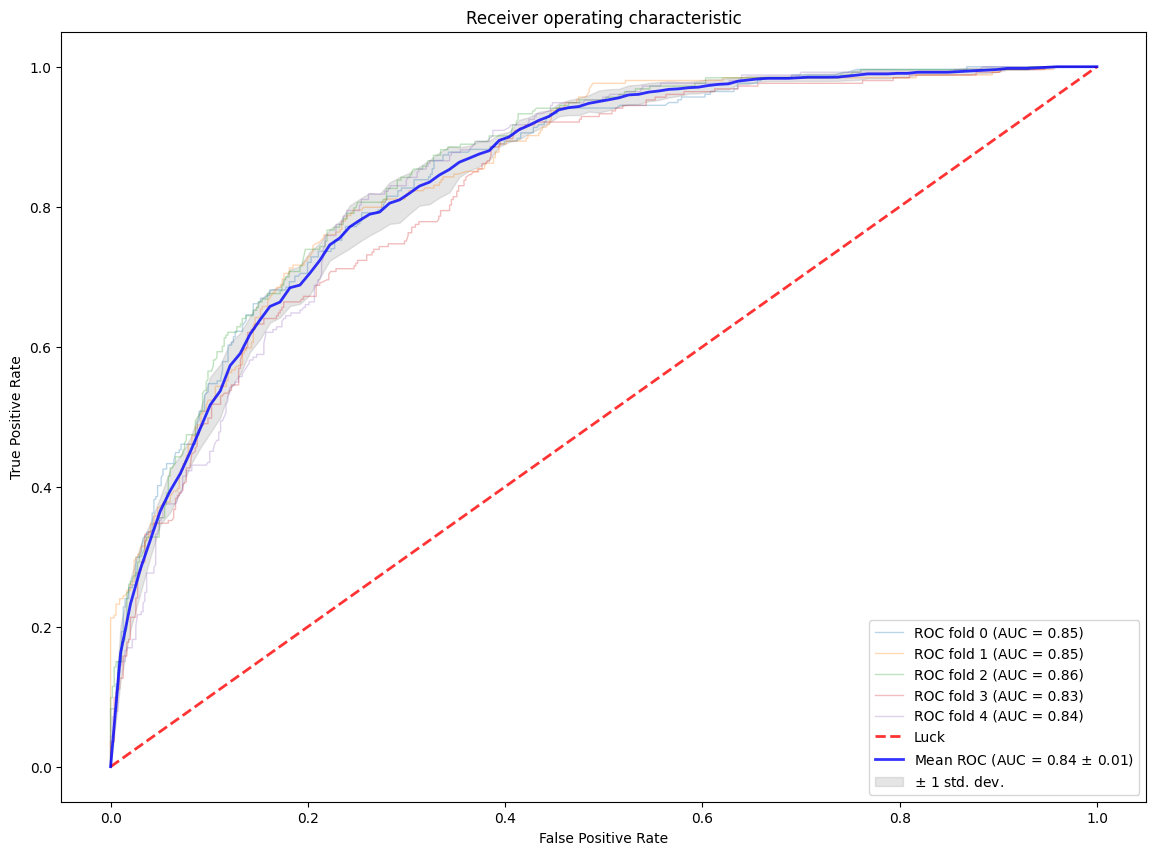

Accaracy list :  [0.78, 0.7725, 0.755, 0.76, 0.76125]
equal opportunity for tpr :  [0.020661469764625795, 0.1270672317792737, 0.1970103831006087, 0.12629623897229533, 0.071301247771836]
equal opportunity for fpr :  [0.028208044338368377, 0.005080057003939972, 0.006534381390593043, 0.023702998572108523, 0.0003533026113671234]
odds difference list :  [0.024434757051497086, 0.06607364439160684, 0.10177238224560087, 0.07499961877220193, 0.03582727519160156]
The mean accuracy is  0.766 ± 0.009
The mean equal opportunity for tpr: (close to 0) 0.108 ± 0.059
The mean equal opportunity for fpr: (close to 0) 0.013 ± 0.011
The mean odds difference: (close to 0) 0.061 ± 0.028
The mean parity difference: (close to 0) 0.567 ± 0.078
The mean disperate impact: (close to 1) 0.155 ± 0.091


In [ ]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig)

  ## CTGANfor each group

In [ ]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1


print(zero_priv_toincrease,zero_nonpriv_toincresed,one_priv_toincresed,one_nonpriv_toincresed)

0 1099 979 1586


# CTGAN On Priv Target Group

In [ ]:
from ctgan import CTGAN

# Fit CTGAN for orig_data_zero_priv

ctgan_zero_priv = CTGAN(verbose=True)
ctgan_zero_priv.fit(orig_data_zero_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_zero_non_priv

ctgan_zero_nonpriv = CTGAN(verbose=True)
ctgan_zero_nonpriv.fit(orig_data_zero_non_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_priv

ctgan_one_priv = CTGAN(verbose=True)
ctgan_one_priv.fit(orig_data_one_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_non_priv

ctgan_one_nonpriv = CTGAN(verbose=True)
ctgan_one_nonpriv.fit(orig_data_one_non_priv , CATEGORICAL, epochs = 200)



/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e93525bfc70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py

Epoch 1, Loss G:  1.0147,Loss D: -0.0249
Epoch 2, Loss G:  1.0014,Loss D: -0.0838
Epoch 3, Loss G:  1.0076,Loss D: -0.0732
Epoch 4, Loss G:  0.9822,Loss D: -0.1337
Epoch 5, Loss G:  0.9211,Loss D: -0.1402
Epoch 6, Loss G:  0.8357,Loss D: -0.2222
Epoch 7, Loss G:  0.6352,Loss D: -0.1512
Epoch 8, Loss G:  0.5512,Loss D:  0.0164
Epoch 9, Loss G:  0.2954,Loss D:  0.1938
Epoch 10, Loss G:  0.4642,Loss D:  0.1853
Epoch 11, Loss G:  0.3679,Loss D:  0.2086
Epoch 12, Loss G:  0.3936,Loss D:  0.1609
Epoch 13, Loss G:  0.4911,Loss D:  0.1048
Epoch 14, Loss G:  0.4794,Loss D:  0.1219
Epoch 15, Loss G:  0.3955,Loss D:  0.0815
Epoch 16, Loss G:  0.3598,Loss D:  0.0670
Epoch 17, Loss G:  0.4343,Loss D:  0.1171
Epoch 18, Loss G:  0.5818,Loss D:  0.0079
Epoch 19, Loss G:  0.5692,Loss D: -0.0780
Epoch 20, Loss G:  0.6400,Loss D:  0.0659
Epoch 21, Loss G:  0.5652,Loss D:  0.0231
Epoch 22, Loss G:  0.5052,Loss D:  0.0615
Epoch 23, Loss G:  0.5152,Loss D: -0.0100
Epoch 24, Loss G:  0.4490,Loss D:  0.0083
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.0260,Loss D:  0.0094
Epoch 2, Loss G:  1.0010,Loss D: -0.0028
Epoch 3, Loss G:  0.9785,Loss D: -0.0004
Epoch 4, Loss G:  0.9678,Loss D: -0.0131
Epoch 5, Loss G:  0.9541,Loss D: -0.0324
Epoch 6, Loss G:  0.9721,Loss D: -0.0184
Epoch 7, Loss G:  0.9023,Loss D: -0.0618
Epoch 8, Loss G:  0.9852,Loss D: -0.0578
Epoch 9, Loss G:  0.9225,Loss D: -0.0954
Epoch 10, Loss G:  0.9009,Loss D: -0.0654
Epoch 11, Loss G:  0.9489,Loss D: -0.1259
Epoch 12, Loss G:  0.7702,Loss D: -0.0914
Epoch 13, Loss G:  0.8424,Loss D: -0.1670
Epoch 14, Loss G:  0.6902,Loss D: -0.1151
Epoch 15, Loss G:  0.6542,Loss D: -0.1511
Epoch 16, Loss G:  0.7137,Loss D: -0.1306
Epoch 17, Loss G:  0.5597,Loss D: -0.2161
Epoch 18, Loss G:  0.5160,Loss D: -0.1469
Epoch 19, Loss G:  0.3258,Loss D: -0.0963
Epoch 20, Loss G:  0.2676,Loss D: -0.1499
Epoch 21, Loss G:  0.2522,Loss D: -0.1436
Epoch 22, Loss G:  0.2951,Loss D: -0.0549
Epoch 23, Loss G:  0.2276,Loss D: -0.0926
Epoch 24, Loss G:  0.1145,Loss D: -0.0263
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  0.9005,Loss D:  0.0260
Epoch 2, Loss G:  0.9782,Loss D: -0.0067
Epoch 3, Loss G:  0.9142,Loss D: -0.0246
Epoch 4, Loss G:  0.9849,Loss D: -0.0526
Epoch 5, Loss G:  0.9746,Loss D: -0.0263
Epoch 6, Loss G:  0.9998,Loss D: -0.0265
Epoch 7, Loss G:  0.9247,Loss D: -0.0299
Epoch 8, Loss G:  0.8946,Loss D: -0.0633
Epoch 9, Loss G:  0.9461,Loss D: -0.0534
Epoch 10, Loss G:  0.8381,Loss D: -0.0456
Epoch 11, Loss G:  0.8253,Loss D: -0.1010
Epoch 12, Loss G:  0.8340,Loss D: -0.0976
Epoch 13, Loss G:  0.8508,Loss D: -0.1075
Epoch 14, Loss G:  0.7318,Loss D: -0.1572
Epoch 15, Loss G:  0.6961,Loss D: -0.1495
Epoch 16, Loss G:  0.7029,Loss D: -0.1692
Epoch 17, Loss G:  0.5269,Loss D: -0.2116
Epoch 18, Loss G:  0.5320,Loss D: -0.1026
Epoch 19, Loss G:  0.4320,Loss D: -0.2292
Epoch 20, Loss G:  0.3957,Loss D: -0.0998
Epoch 21, Loss G:  0.4224,Loss D: -0.2223
Epoch 22, Loss G:  0.2906,Loss D:  0.0035
Epoch 23, Loss G:  0.3734,Loss D: -0.0643
Epoch 24, Loss G:  0.1290,Loss D: -0.0652
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.0538,Loss D:  0.0112
Epoch 2, Loss G:  1.1080,Loss D: -0.0217


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


Epoch 3, Loss G:  1.0390,Loss D: -0.0398
Epoch 4, Loss G:  1.0451,Loss D:  0.0399
Epoch 5, Loss G:  1.0733,Loss D:  0.0135
Epoch 6, Loss G:  1.0869,Loss D: -0.0237
Epoch 7, Loss G:  1.0552,Loss D:  0.0017
Epoch 8, Loss G:  1.0484,Loss D: -0.0483
Epoch 9, Loss G:  0.9901,Loss D: -0.0366
Epoch 10, Loss G:  0.9168,Loss D: -0.0412
Epoch 11, Loss G:  0.9515,Loss D: -0.0864
Epoch 12, Loss G:  0.9050,Loss D: -0.1245
Epoch 13, Loss G:  0.8716,Loss D: -0.0728
Epoch 14, Loss G:  0.7998,Loss D: -0.0840
Epoch 15, Loss G:  0.7807,Loss D: -0.1109
Epoch 16, Loss G:  0.7758,Loss D: -0.0800
Epoch 17, Loss G:  0.7287,Loss D: -0.1167
Epoch 18, Loss G:  0.7077,Loss D: -0.0115
Epoch 19, Loss G:  0.6167,Loss D: -0.0600
Epoch 20, Loss G:  0.5816,Loss D: -0.1137
Epoch 21, Loss G:  0.5744,Loss D: -0.0742
Epoch 22, Loss G:  0.4760,Loss D: -0.0758
Epoch 23, Loss G:  0.3645,Loss D: -0.0352
Epoch 24, Loss G:  0.3905,Loss D: -0.0538
Epoch 25, Loss G:  0.3412,Loss D:  0.0393
Epoch 26, Loss G:  0.3274,Loss D: -0.0716

In [ ]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1

#create samples using ctgan with zero_priv
zero_priv_samples = ctgan_zero_priv.sample(zero_priv_toincrease)


#create samples using ctgan with zero_nonpriv
zero_nonpriv_samples = ctgan_zero_nonpriv.sample(zero_nonpriv_toincresed)


#create samples using ctgan with one_priv
one_priv_samples = ctgan_one_priv.sample(one_priv_toincresed)


#create samples using ctgan with zero_priv
one_nonpriv_samples = ctgan_one_nonpriv.sample(one_nonpriv_toincresed)



In [ ]:
Upsampled_Dataset = pd.concat([orig_dataset, zero_priv_samples, zero_nonpriv_samples, one_priv_samples, one_nonpriv_samples], ignore_index=True)

Upsampled_Dataset = Upsampled_Dataset.reset_index()


In [ ]:
Upsampled_Dataset

,index,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
1,1,0,1,German,Golf,67,False,True,False,False,2,True,bachelor,A,0
2,2,1,0,Dutch,Running,67,False,True,True,False,0,True,master,A,0
3,3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
4,4,1,1,German,Golf,59,False,False,False,False,1,False,master,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7659,7659,0,0,German,Rugby,71,True,True,False,True,2,True,bachelor,C,1
7660,7660,0,0,Dutch,Football,77,False,True,False,False,2,True,master,D,1
7661,7661,1,0,Dutch,Football,77,False,True,False,True,2,False,master,C,1
7662,7662,0,0,Belgian,Swimming,72,True,False,True,False,2,True,phd,B,1


In [ ]:
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]

Upsampled_df_features = encoder.transform(Upsampled_df_features)
Upsampled_df_features

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company
0,1,0,0.310777,0.291727,70,0.270350,0.323162,0.291976,0.274256,1,0.294435,0.453441,0.424
1,0,1,0.310777,0.275542,67,0.270350,0.303125,0.291976,0.274256,2,0.294435,0.204637,0.424
2,1,0,0.318598,0.207120,67,0.270350,0.303125,0.402453,0.274256,0,0.294435,0.423403,0.424
3,0,0,0.318598,0.299674,70,0.270350,0.303125,0.291976,0.274256,1,0.294435,0.423403,0.424
4,1,1,0.310777,0.275542,59,0.270350,0.323162,0.291976,0.274256,1,0.335970,0.423403,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7659,0,0,0.310777,0.401481,71,0.467588,0.303125,0.291976,0.461454,2,0.294435,0.204637,0.258
7660,0,0,0.318598,0.353206,77,0.270350,0.303125,0.291976,0.274256,2,0.294435,0.423403,0.276
7661,1,0,0.318598,0.353206,77,0.270350,0.303125,0.291976,0.461454,2,0.335970,0.423403,0.258
7662,0,0,0.308756,0.291727,72,0.467588,0.323162,0.402453,0.274256,2,0.294435,0.453441,0.309


performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[534 232]
 [121 646]] 
accuracy:  0.7697325505544683 precision:  0.7357630979498861 recall:  0.8422425032594524 fpr:  0.3028720626631854 tpr:  0.8422425032594524 fn+fp 353
performance for 0 sub-group:
conf matrix:
  [[262 116]
 [ 57 342]] 
accuracy:  0.7773487773487774 precision:  0.7467248908296943 recall:  0.8571428571428571 fpr:  0.30687830687830686 tpr:  0.8571428571428571 fn+fp 173
performance for 1 sub-group:
conf matrix:
  [[272 116]
 [ 64 304]] 
accuracy:  0.7619047619047619 precision:  0.7238095238095238 recall:  0.8260869565217391 fpr:  0.29896907216494845 tpr:  0.8260869565217391 fn+fp 180
bias metrics:
equal opportunity for tpr: (close to 0) 0.03105590062111796
equal opportunity for fpr: (close to 0) 0.007909234713358415
avarage absolute odds difference: (close to 0) 0.019482567667238188
statistical parity difference: (close to 0)  0.043280182232346254
disparate_impact: (close to 1)  0.438670

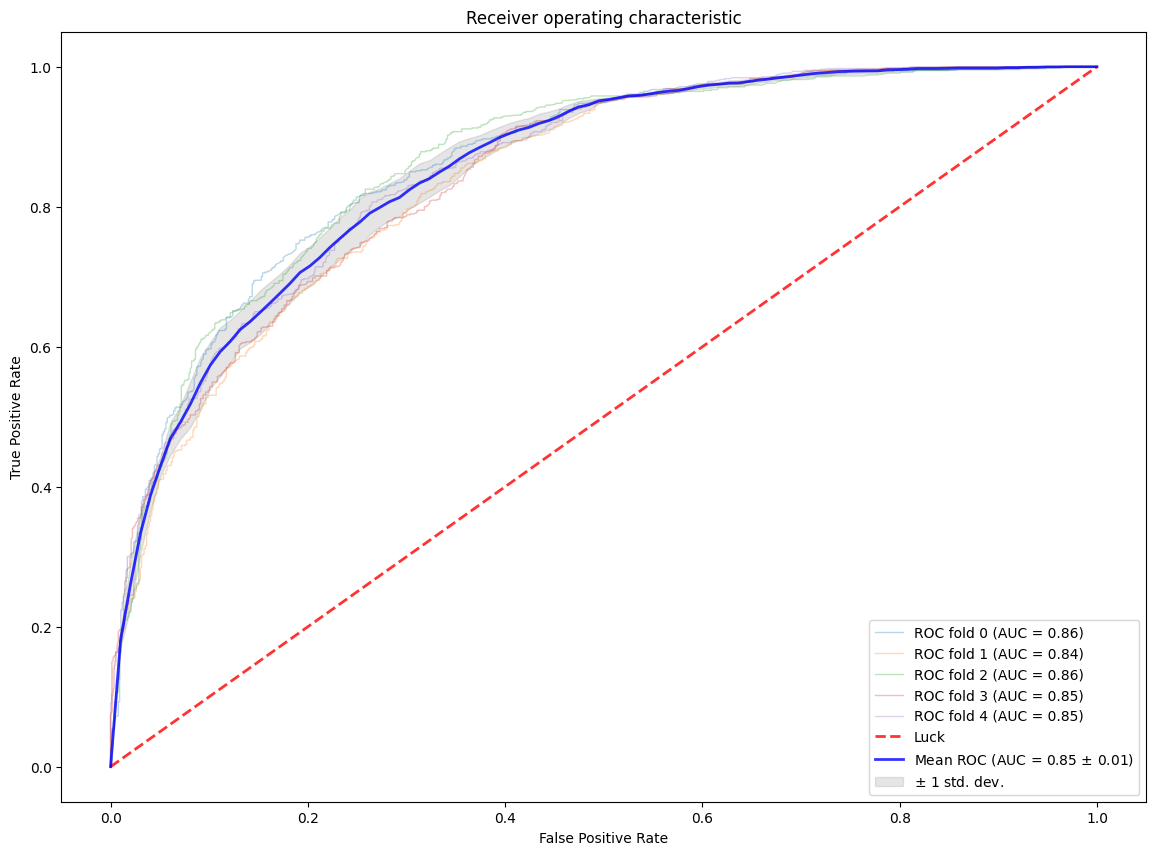

Accaracy list :  [0.7697325505544683, 0.7495107632093934, 0.7821265492498369, 0.741030658838878, 0.762402088772846]
equal opportunity for tpr :  [0.03105590062111796, 0.05063514947093539, 0.048484848484848464, 0.058477255809824324, 0.10528218243819265]
equal opportunity for fpr :  [0.007909234713358415, 0.05810560192003489, 0.002951537655907832, 0.047619047619047616, 0.04155498721227624]
odds difference list :  [0.019482567667238188, 0.05437037569548514, 0.025718193070378148, 0.05304815171443597, 0.07341858482523445]
The mean accuracy is  0.761 ± 0.015
The mean equal opportunity for tpr: (close to 0) 0.059 ± 0.025
The mean equal opportunity for fpr: (close to 0) 0.032 ± 0.022
The mean odds difference: (close to 0) 0.045 ± 0.020
The mean parity difference: (close to 0) 0.040 ± 0.009
The mean disperate impact: (close to 1) 0.454 ± 0.025


In [ ]:
y_upsampled = Upsampled_Dataset[TARGET_COL]

# Check fairness metrics again
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Store metrics values
# op_diff_values.append(mean(debias_op_diff))
# dis_impact_values.append(mean(debias_dis_impact))
# debias_acc_values.append(mean(debias_acc))
# debias_odds_diff_values.append(mean(debias_od_diff))
# alfa_counter += 1
# print('alfa counter is :',alfa_counter)
# print ('debias_op_diff is {} , orig_op_diff is {}'.format(mean(debias_op_diff), mean(orig_op_diff)))
# print ('debias_dis_impact is {} , orig_dis_impact is {}'.format(mean(debias_dis_impact), mean(orig_dis_impact)) )

In [ ]:
#Based on class
Upsampled_Dataset_one , Upsampled_Dataset_zero = [x for _, x in Upsampled_Dataset.groupby(Upsampled_Dataset[TARGET_COL] == 0)]

#Based on priv feature
Upsampled_df_one_priv, Upsampled_df_one_non_priv = [x for _, x in Upsampled_Dataset_one.groupby(Upsampled_Dataset_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
Upsampled_df_zero_priv, Upsampled_df_zero_non_priv = [x for _, x in Upsampled_Dataset_zero.groupby(Upsampled_Dataset_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(Upsampled_df_one_priv.shape,Upsampled_df_one_non_priv.shape,Upsampled_df_zero_priv.shape,Upsampled_df_zero_non_priv.shape)

(1916, 15) (1916, 15) (1916, 15) (1916, 15)


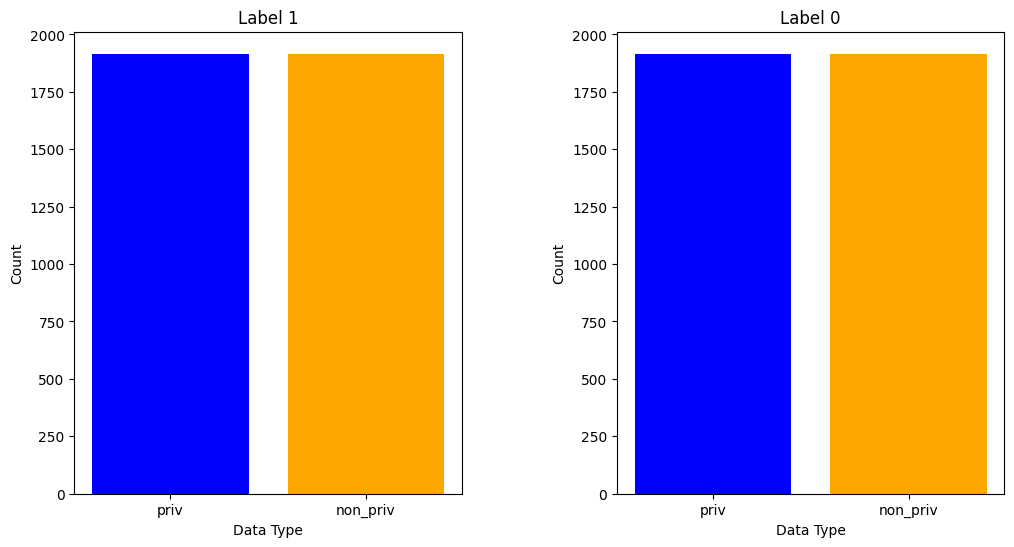

In [ ]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [Upsampled_df_one_priv.shape[0], Upsampled_df_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [Upsampled_df_zero_priv.shape[0], Upsampled_df_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[534 232]
 [121 646]] 
accuracy:  0.7697325505544683 precision:  0.7357630979498861 recall:  0.8422425032594524 fpr:  0.3028720626631854 tpr:  0.8422425032594524 fn+fp 353
performance for 0 sub-group:
conf matrix:
  [[262 116]
 [ 57 342]] 
accuracy:  0.7773487773487774 precision:  0.7467248908296943 recall:  0.8571428571428571 fpr:  0.30687830687830686 tpr:  0.8571428571428571 fn+fp 173
performance for 1 sub-group:
conf matrix:
  [[272 116]
 [ 64 304]] 
accuracy:  0.7619047619047619 precision:  0.7238095238095238 recall:  0.8260869565217391 fpr:  0.29896907216494845 tpr:  0.8260869565217391 fn+fp 180
bias metrics:
equal opportunity for tpr: (close to 0) 0.03105590062111796
equal opportunity for fpr: (close to 0) 0.007909234713358415
avarage absolute odds difference: (close to 0) 0.019482567667238188
statistical parity difference: (close to 0)  0.043280182232346254
disparate_impact: (close to 1)  0.438670

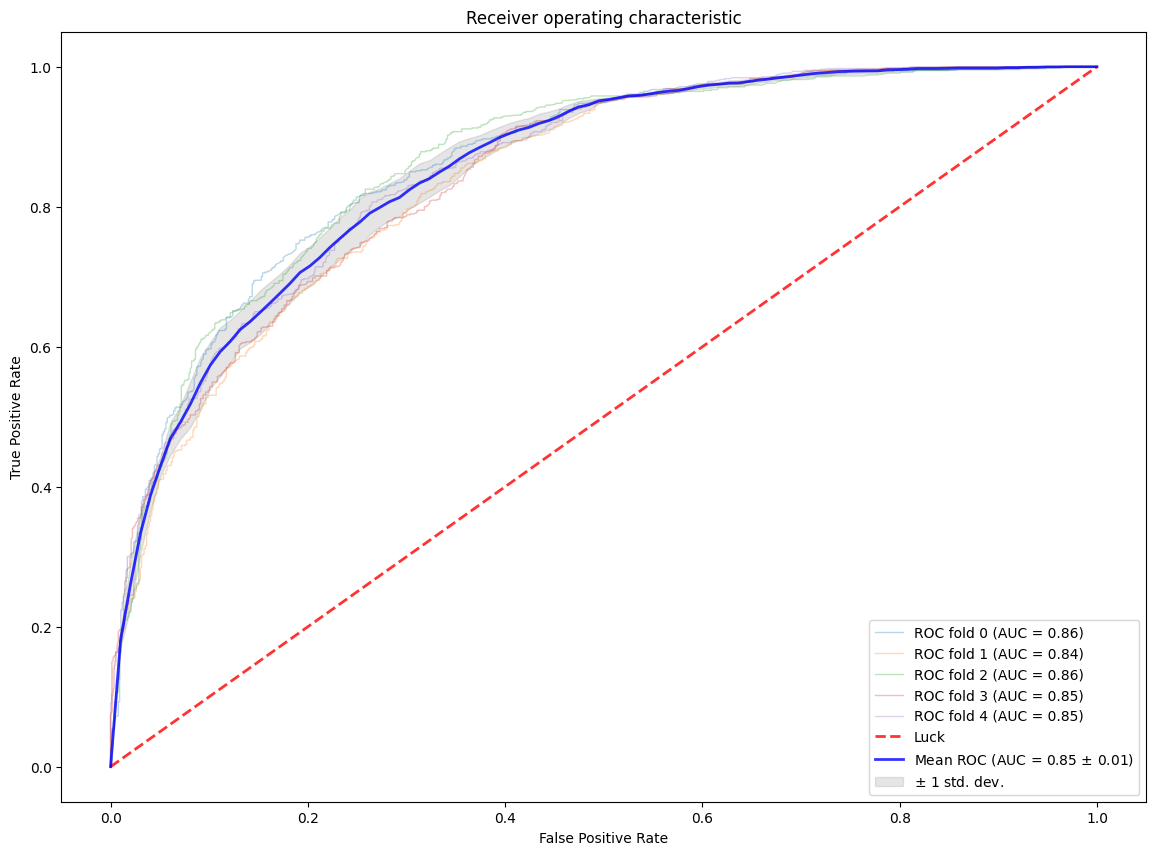

Accaracy list :  [0.7697325505544683, 0.7495107632093934, 0.7821265492498369, 0.741030658838878, 0.762402088772846]
equal opportunity for tpr :  [0.03105590062111796, 0.05063514947093539, 0.048484848484848464, 0.058477255809824324, 0.10528218243819265]
equal opportunity for fpr :  [0.007909234713358415, 0.05810560192003489, 0.002951537655907832, 0.047619047619047616, 0.04155498721227624]
odds difference list :  [0.019482567667238188, 0.05437037569548514, 0.025718193070378148, 0.05304815171443597, 0.07341858482523445]
The mean accuracy is  0.761 ± 0.015
The mean equal opportunity for tpr: (close to 0) 0.059 ± 0.025
The mean equal opportunity for fpr: (close to 0) 0.032 ± 0.022
The mean odds difference: (close to 0) 0.045 ± 0.020
The mean parity difference: (close to 0) 0.040 ± 0.009
The mean disperate impact: (close to 1) 0.454 ± 0.025


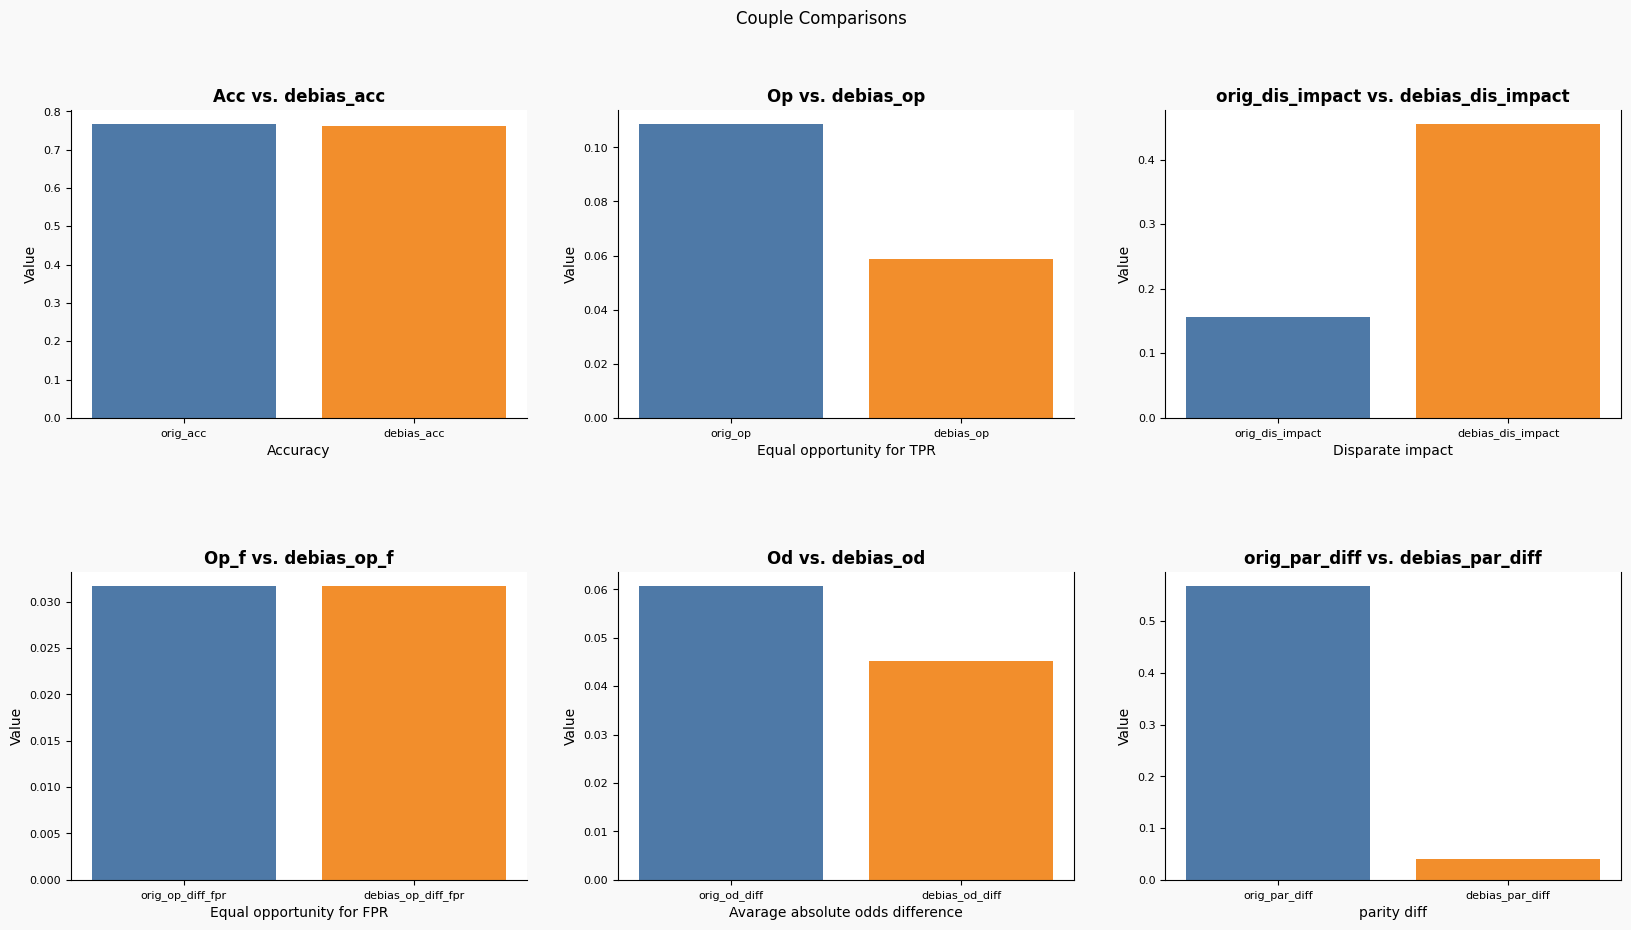

In [ ]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines



In [ ]:
# Record the end time
end_time = time.time()

In [ ]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 1.9481 minutes
